In [1]:
import composuite
from diffusion.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


def compute_error(agent_dataset, synthetic_dataset):

    num_samples = 1000
    
    agent_observations = agent_dataset['observations']
    random_indices = np.random.choice(agent_observations.shape[0], num_samples, replace=False)
    sampled_agent_observations = agent_observations[random_indices]

    synthetic_observations = synthetic_dataset['observations']
    random_indices = np.random.choice(synthetic_observations.shape[0], num_samples, replace=False)
    sampled_synthetic_observations = synthetic_observations[random_indices]

    mean_agent = np.mean(sampled_agent_observations, axis=0)
    mean_synthetic = np.mean(sampled_synthetic_observations, axis=0)

    error = np.linalg.norm(mean_agent - mean_synthetic)
    
    return error


def wasserstein_distance(agent_dataset, synthetic_dataset, key='observations', num_samples=1000):
    
    agent_data = agent_dataset[key]
    random_indices = np.random.choice(agent_data.shape[0], num_samples, replace=False)
    sampled_agent_data = agent_data[random_indices]

    synthetic_data = synthetic_dataset[key]
    random_indices = np.random.choice(synthetic_data.shape[0], num_samples, replace=False)
    sampled_synthetic_data = synthetic_data[random_indices]
    
    n_dims = sampled_agent_data.shape[1]
    w_distances = []
    
    for dim in range(n_dims):
        w_dist = stats.wasserstein_distance(sampled_agent_data[:, dim], sampled_synthetic_data[:, dim])
        w_distances.append(w_dist)
    
    return np.mean(w_distances), w_distances

In [2]:
dataset_type = 'expert'
base_agent_data_path = '/Users/shubhankar/Developer/compositional-rl-synth-data/data'
base_synthetic_data_path = '/Users/shubhankar/Developer/compositional-rl-synth-data/cluster_results/Quan/180M/'

In [3]:
representative_indicators_env = composuite.make('IIWA', 'Plate', 'ObjectWall', 'Push', use_task_id_obs=True, ignore_done=False)
representative_env = composuite.make('IIWA', 'Plate', 'ObjectWall', 'Push', use_task_id_obs=False, ignore_done=False)

/Users/shubhankar/Developer/compositional-rl-synth-data/.venv/lib/python3.9/site-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
# runs = ['cond_diff_17', 'cond_diff_7', 'cond_diff_8', 
#         'cond_diff_10', 'cond_diff_15', 'cond_diff_19', 
#         'cond_diff_22', 'cond_diff_18', 'cond_diff_23', 
#         'cond_diff_20', 'cond_diff_24', 'cond_diff_25', 
#         'cond_diff_21']
# num_train_tasks = [16, 32, 48, 64, 80, 96, 112, 128, 144, 176, 192, 208, 244]

runs = ['64', '128', '200']
num_train_tasks = [16, 128, 200]

In [5]:
all_train_obs_means = []
all_train_obs_stds = []
all_test_obs_means = []
all_test_obs_stds = []

all_train_act_means = []
all_train_act_stds = []
all_test_act_means = []
all_test_act_stds = []

all_train_obs_per_dim = []
all_test_obs_per_dim = []
all_train_act_per_dim = []
all_test_act_per_dim = []

for run in tqdm(runs, desc='Run'):
    train_tasks = [
        task for task in os.listdir(os.path.join(base_synthetic_data_path, run, 'train'))
        if not task.startswith('.')
    ]
    obs_errors = []
    act_errors = []
    obs_per_dim_errors = []
    act_per_dim_errors = []
    
    for task in train_tasks:
        robot, obj, obst, subtask = task.split('_')
        agent_dataset = load_single_composuite_dataset(base_path=base_agent_data_path, 
                                                       dataset_type='expert', 
                                                       robot=robot, obj=obj, 
                                                       obst=obst, task=subtask)
        agent_dataset = transitions_dataset(agent_dataset)
        agent_dataset, _ = remove_indicator_vectors(representative_indicators_env.modality_dims, agent_dataset)

        synthetic_dataset = load_single_synthetic_dataset(base_path=os.path.join(base_synthetic_data_path, run, 'train'),
                                                          robot=robot, obj=obj, 
                                                          obst=obst, task=subtask)
        
        # Compute Wasserstein distance for observations (mean and per-dimension)
        mean_obs_dist, obs_dists = wasserstein_distance(agent_dataset, synthetic_dataset, key='observations')
        obs_errors.append(mean_obs_dist)
        obs_per_dim_errors.append(np.array(obs_dists))
        
        # Compute Wasserstein distance for actions (mean and per-dimension)
        mean_act_dist, act_dists = wasserstein_distance(agent_dataset, synthetic_dataset, key='actions')
        act_errors.append(mean_act_dist)
        act_per_dim_errors.append(np.array(act_dists))
    
    all_train_obs_means.append(np.mean(obs_errors))
    all_train_obs_stds.append(np.std(obs_errors))
    all_train_act_means.append(np.mean(act_errors))
    all_train_act_stds.append(np.std(act_errors))
    
    # Compute average per-dimension errors across all train tasks
    all_train_obs_per_dim.append(np.mean(np.stack(obs_per_dim_errors, axis=0), axis=0))
    all_train_act_per_dim.append(np.mean(np.stack(act_per_dim_errors, axis=0), axis=0))

    test_tasks = [
        task for task in os.listdir(os.path.join(base_synthetic_data_path, run, 'test'))
        if not task.startswith('.')
    ]
    obs_errors = []
    act_errors = []
    obs_per_dim_errors = []
    act_per_dim_errors = []
    
    for task in test_tasks:
        robot, obj, obst, subtask = task.split('_')
        agent_dataset = load_single_composuite_dataset(base_path=base_agent_data_path, 
                                                       dataset_type='expert', 
                                                       robot=robot, obj=obj, 
                                                       obst=obst, task=subtask)
        agent_dataset = transitions_dataset(agent_dataset)
        agent_dataset, _ = remove_indicator_vectors(representative_indicators_env.modality_dims, agent_dataset)

        synthetic_dataset = load_single_synthetic_dataset(base_path=os.path.join(base_synthetic_data_path, run, 'test'),
                                                        robot=robot, obj=obj, 
                                                        obst=obst, task=subtask)
        
        # Compute Wasserstein distance for observations (mean and per-dimension)
        mean_obs_dist, obs_dists = wasserstein_distance(agent_dataset, synthetic_dataset, key='observations')
        obs_errors.append(mean_obs_dist)
        obs_per_dim_errors.append(np.array(obs_dists))
        
        # Compute Wasserstein distance for actions (mean and per-dimension)
        mean_act_dist, act_dists = wasserstein_distance(agent_dataset, synthetic_dataset, key='actions')
        act_errors.append(mean_act_dist)
        act_per_dim_errors.append(np.array(act_dists))
    
    all_test_obs_means.append(np.mean(obs_errors))
    all_test_obs_stds.append(np.std(obs_errors))
    all_test_act_means.append(np.mean(act_errors))
    all_test_act_stds.append(np.std(act_errors))
    
    # Compute average per-dimension errors across all test tasks
    all_test_obs_per_dim.append(np.mean(np.stack(obs_per_dim_errors, axis=0), axis=0))
    all_test_act_per_dim.append(np.mean(np.stack(act_per_dim_errors, axis=0), axis=0))

Run: 100%|██████████| 3/3 [01:51<00:00, 37.29s/it]


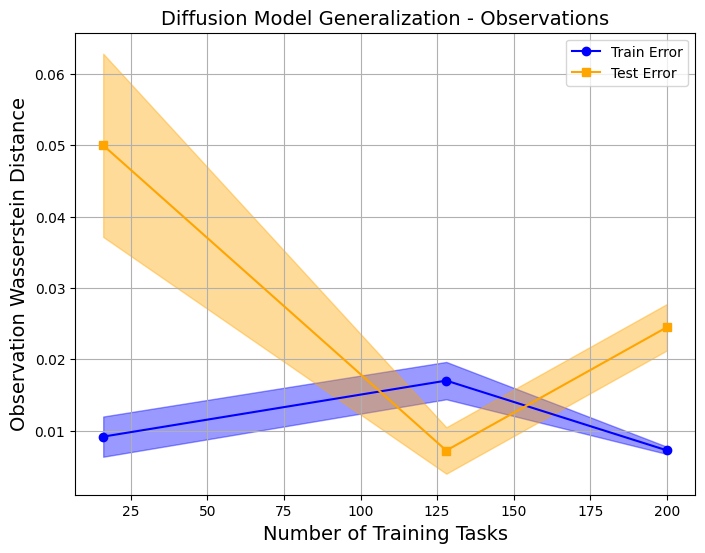

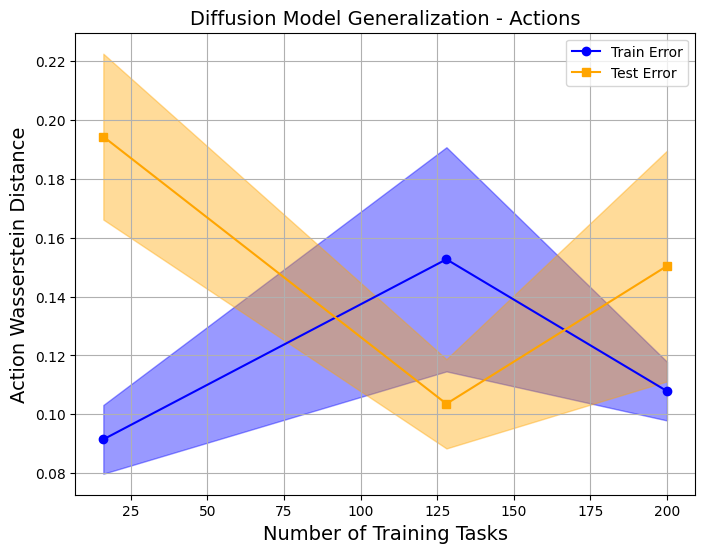

In [6]:
# Convert lists to numpy arrays
all_train_obs_means = np.array(all_train_obs_means)
all_train_obs_stds = np.array(all_train_obs_stds)
all_test_obs_means = np.array(all_test_obs_means)
all_test_obs_stds = np.array(all_test_obs_stds)
all_train_act_means = np.array(all_train_act_means)
all_train_act_stds = np.array(all_train_act_stds)
all_test_act_means = np.array(all_test_act_means)
all_test_act_stds = np.array(all_test_act_stds)

# Plot observation errors
plt.figure(figsize=(8, 6))
plt.plot(num_train_tasks, all_train_obs_means, label='Train Error', marker='o', linestyle='-', color='blue')
plt.plot(num_train_tasks, all_test_obs_means, label='Test Error', marker='s', linestyle='-', color='orange')

plt.fill_between(
    num_train_tasks,
    all_train_obs_means - all_train_obs_stds,
    all_train_obs_means + all_train_obs_stds,
    color='blue', alpha=0.4
)
plt.fill_between(
    num_train_tasks,
    all_test_obs_means - all_test_obs_stds,
    all_test_obs_means + all_test_obs_stds,
    color='orange', alpha=0.4
)

plt.xlabel('Number of Training Tasks', fontsize=14)
plt.ylabel('Observation Wasserstein Distance', fontsize=14)
plt.title('Diffusion Model Generalization - Observations', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot action errors
plt.figure(figsize=(8, 6))
plt.plot(num_train_tasks, all_train_act_means, label='Train Error', marker='o', linestyle='-', color='blue')
plt.plot(num_train_tasks, all_test_act_means, label='Test Error', marker='s', linestyle='-', color='orange')

plt.fill_between(
    num_train_tasks,
    all_train_act_means - all_train_act_stds,
    all_train_act_means + all_train_act_stds,
    color='blue', alpha=0.4
)
plt.fill_between(
    num_train_tasks,
    all_test_act_means - all_test_act_stds,
    all_test_act_means + all_test_act_stds,
    color='orange', alpha=0.4
)

plt.xlabel('Number of Training Tasks', fontsize=14)
plt.ylabel('Action Wasserstein Distance', fontsize=14)
plt.title('Diffusion Model Generalization - Actions', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Plotting observation dimensions...


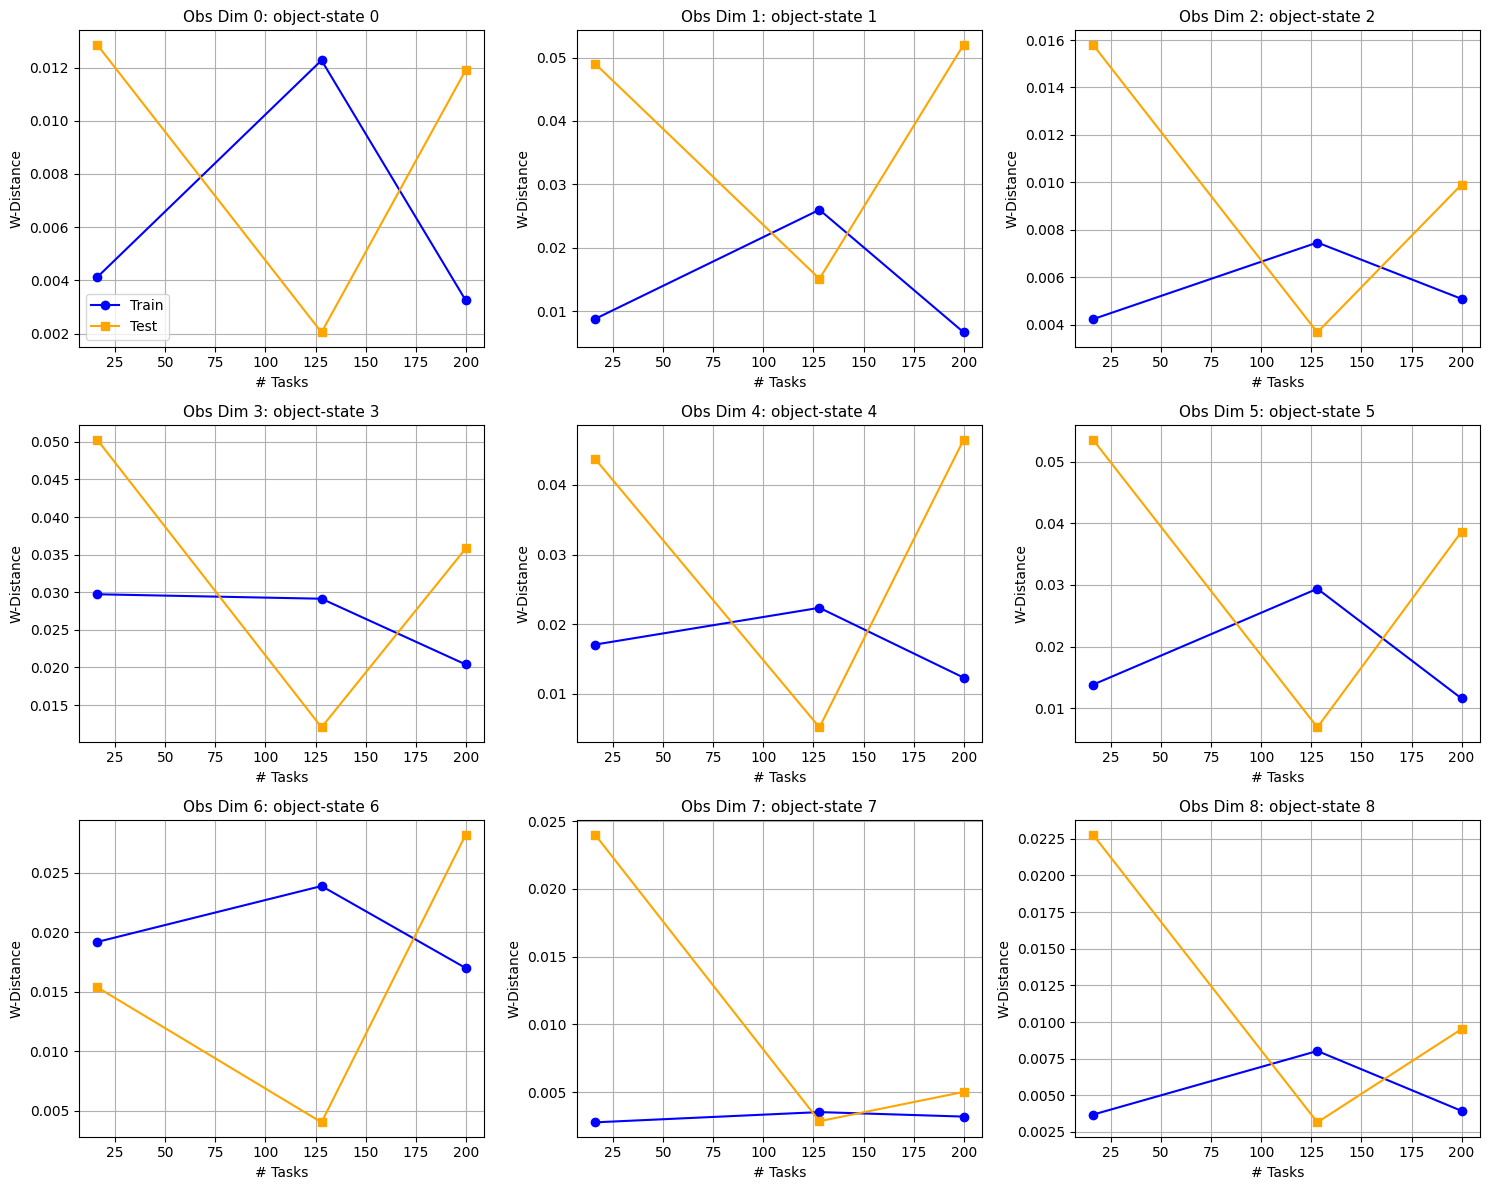

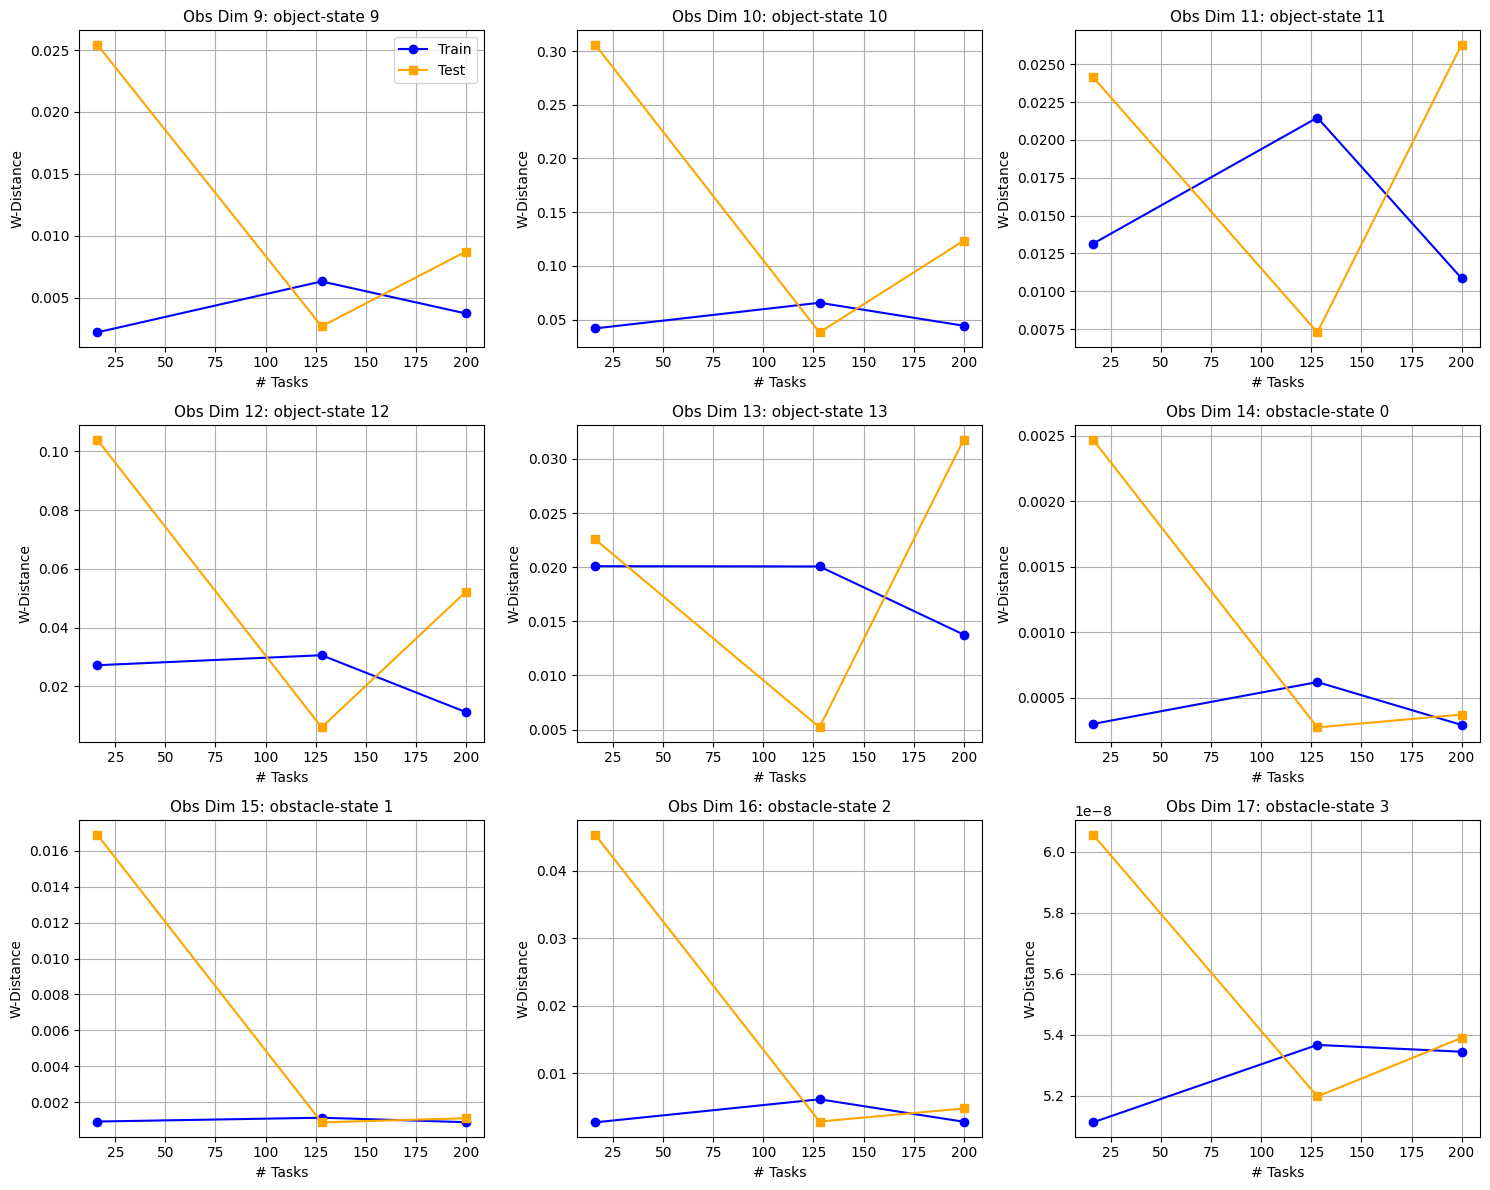

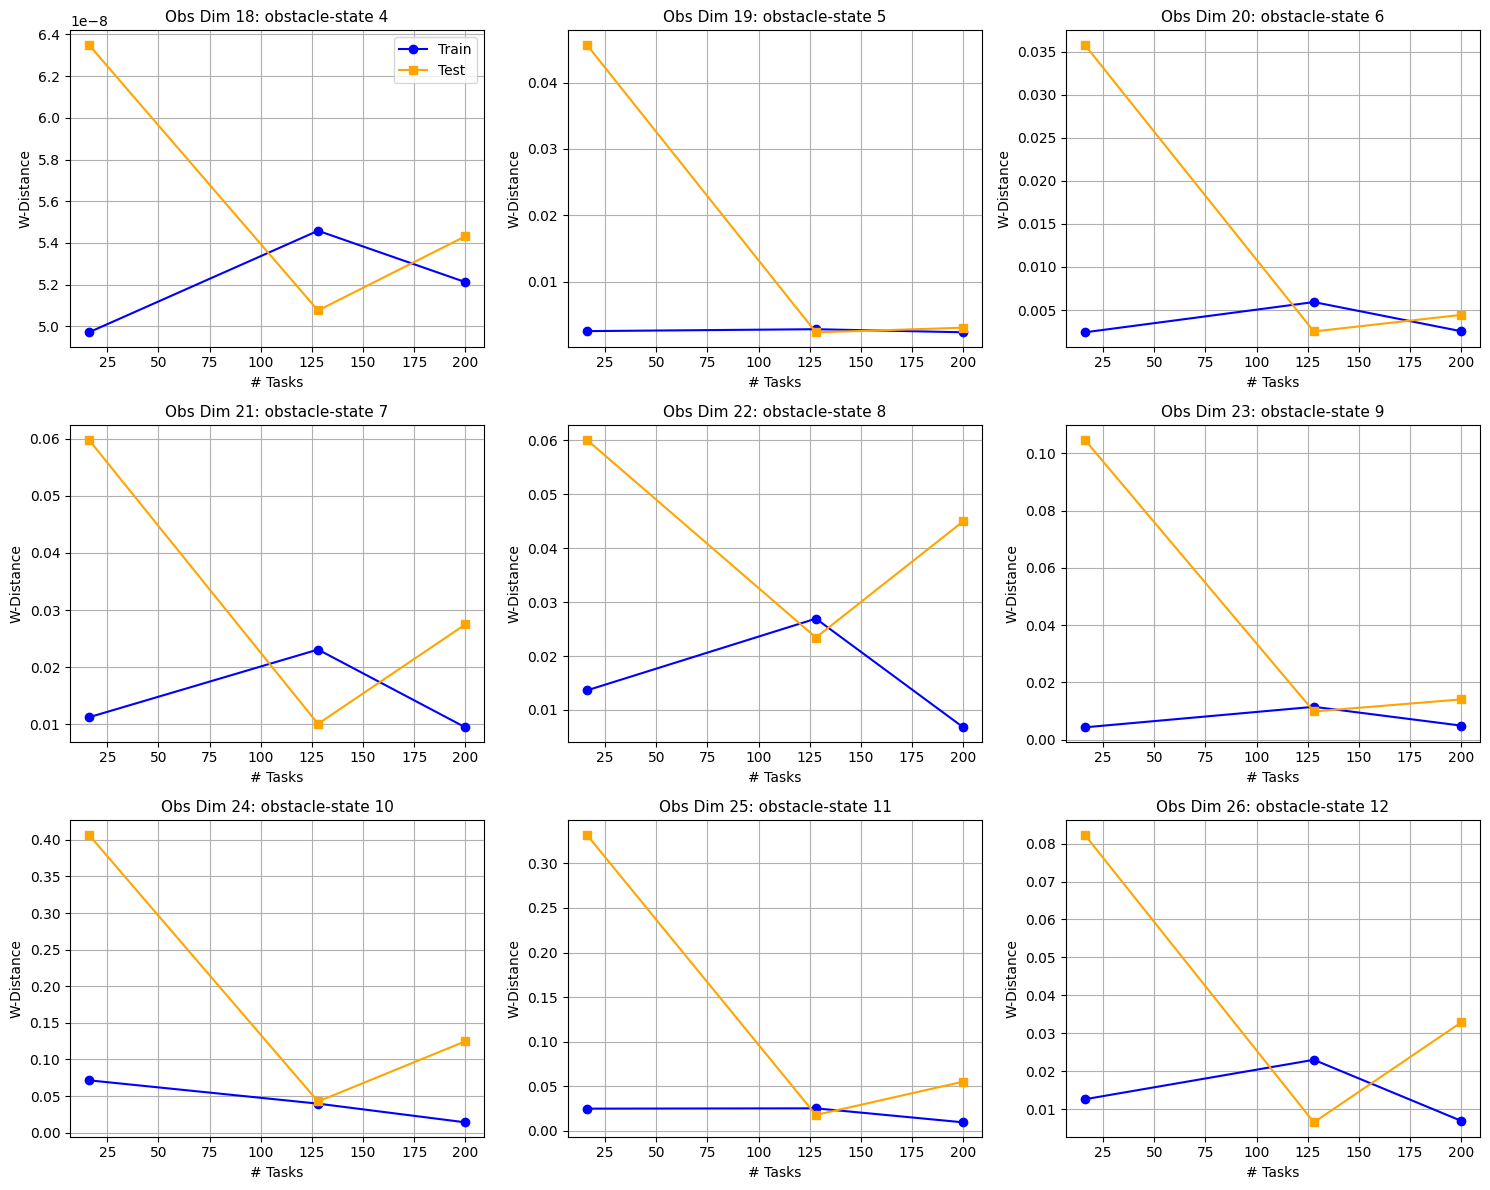

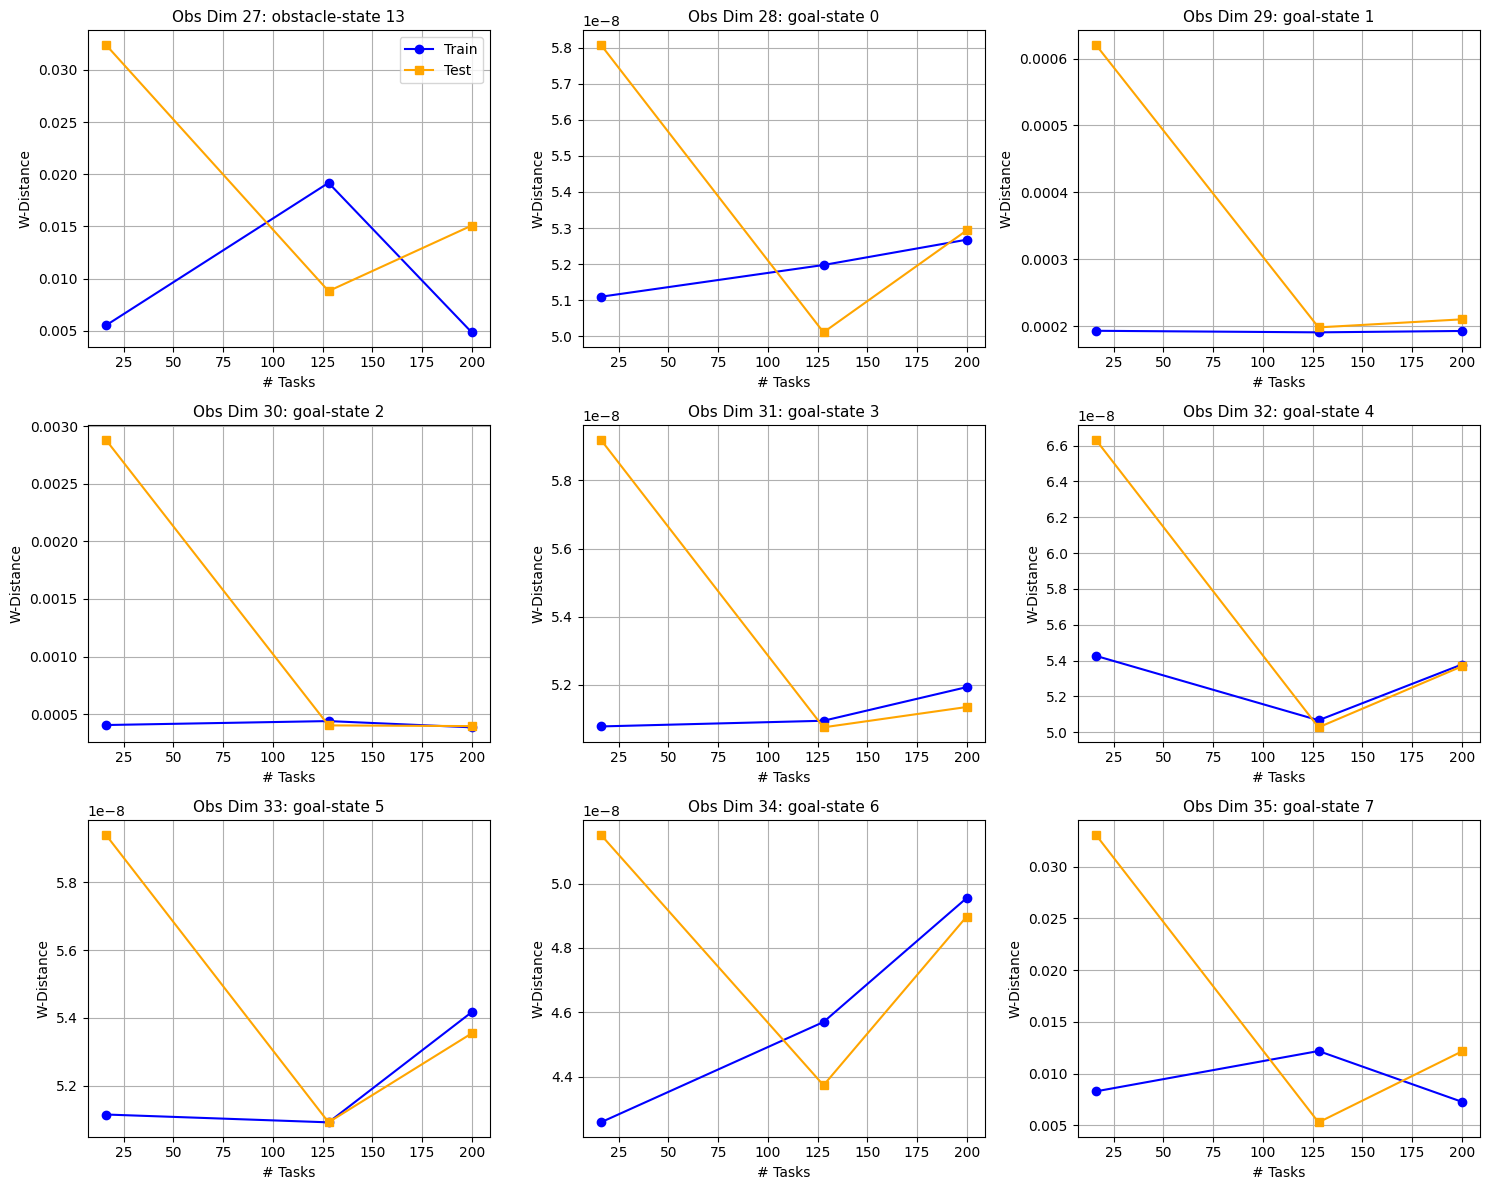

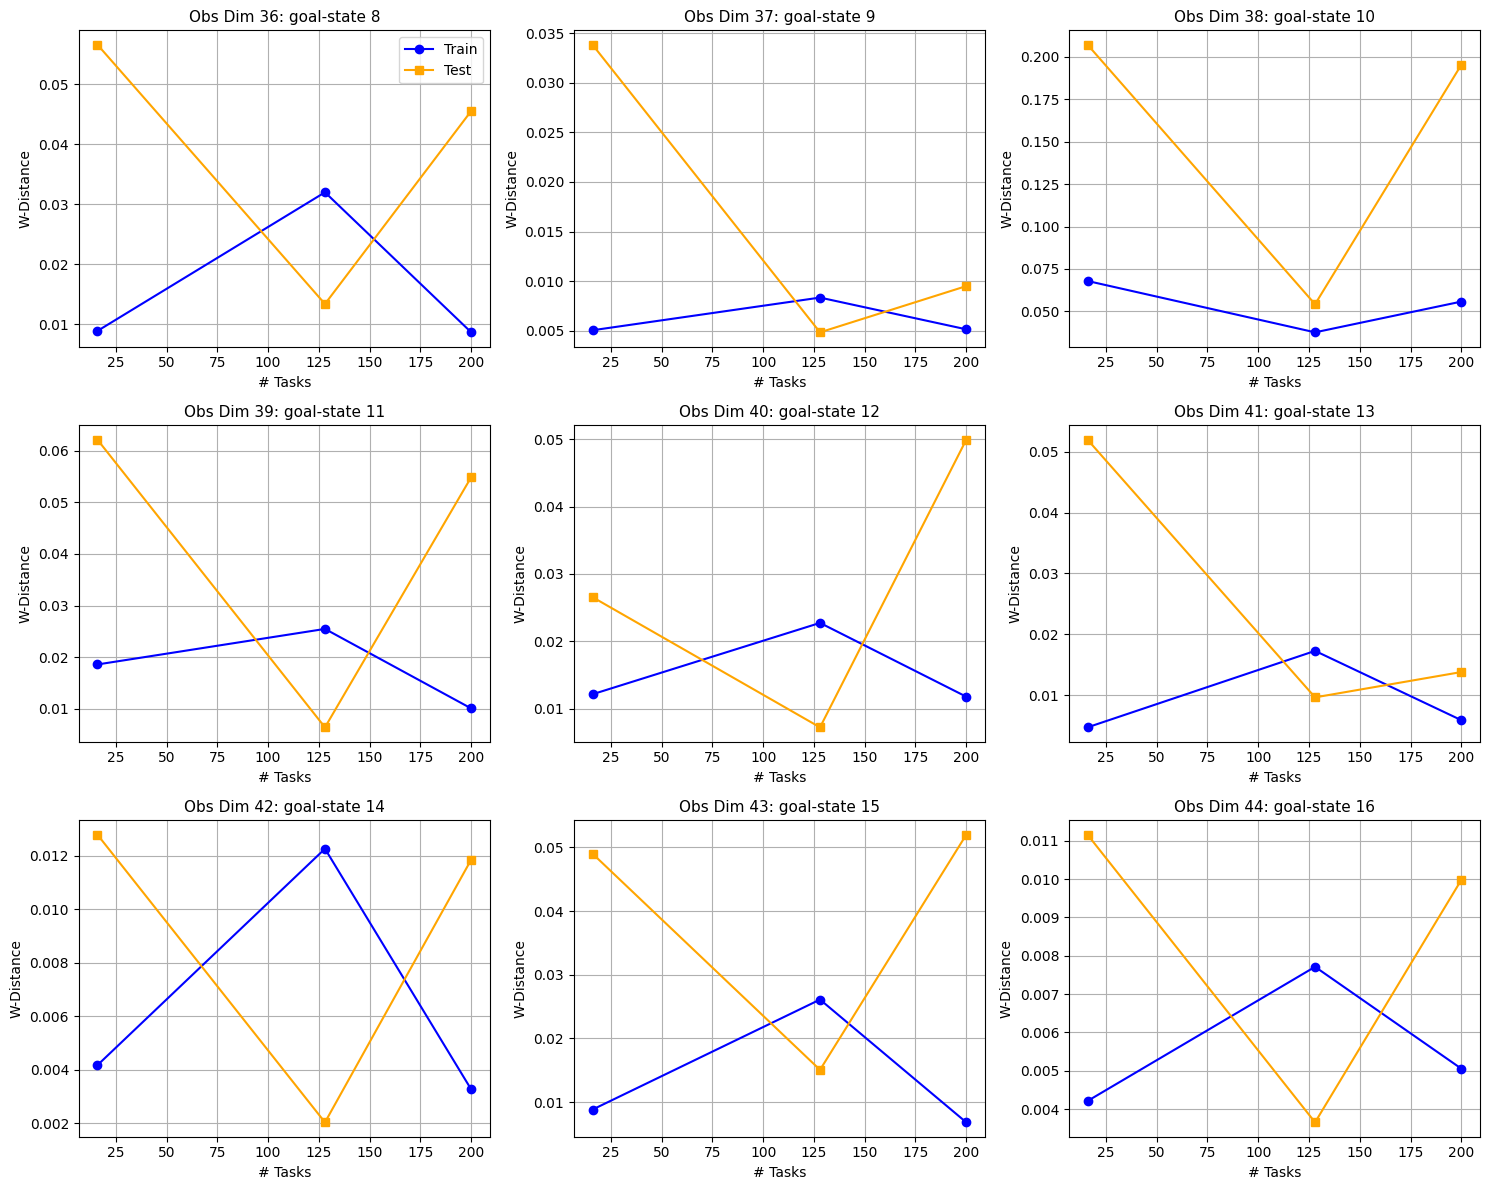

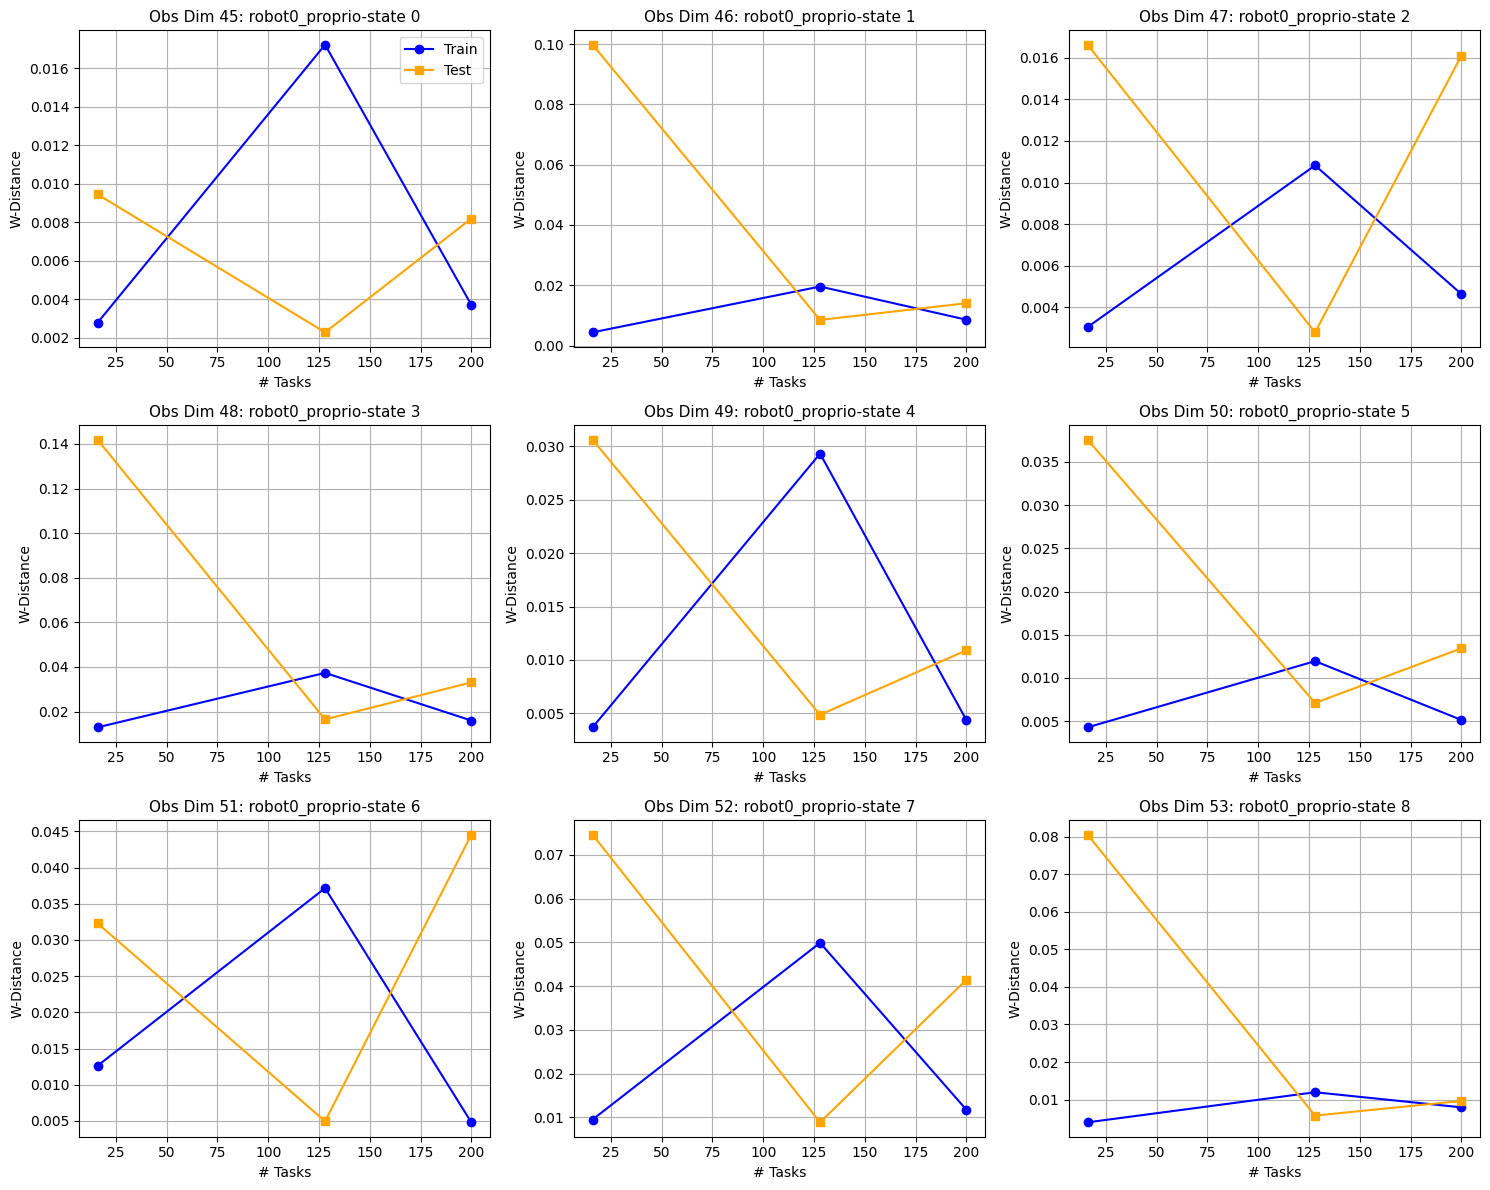

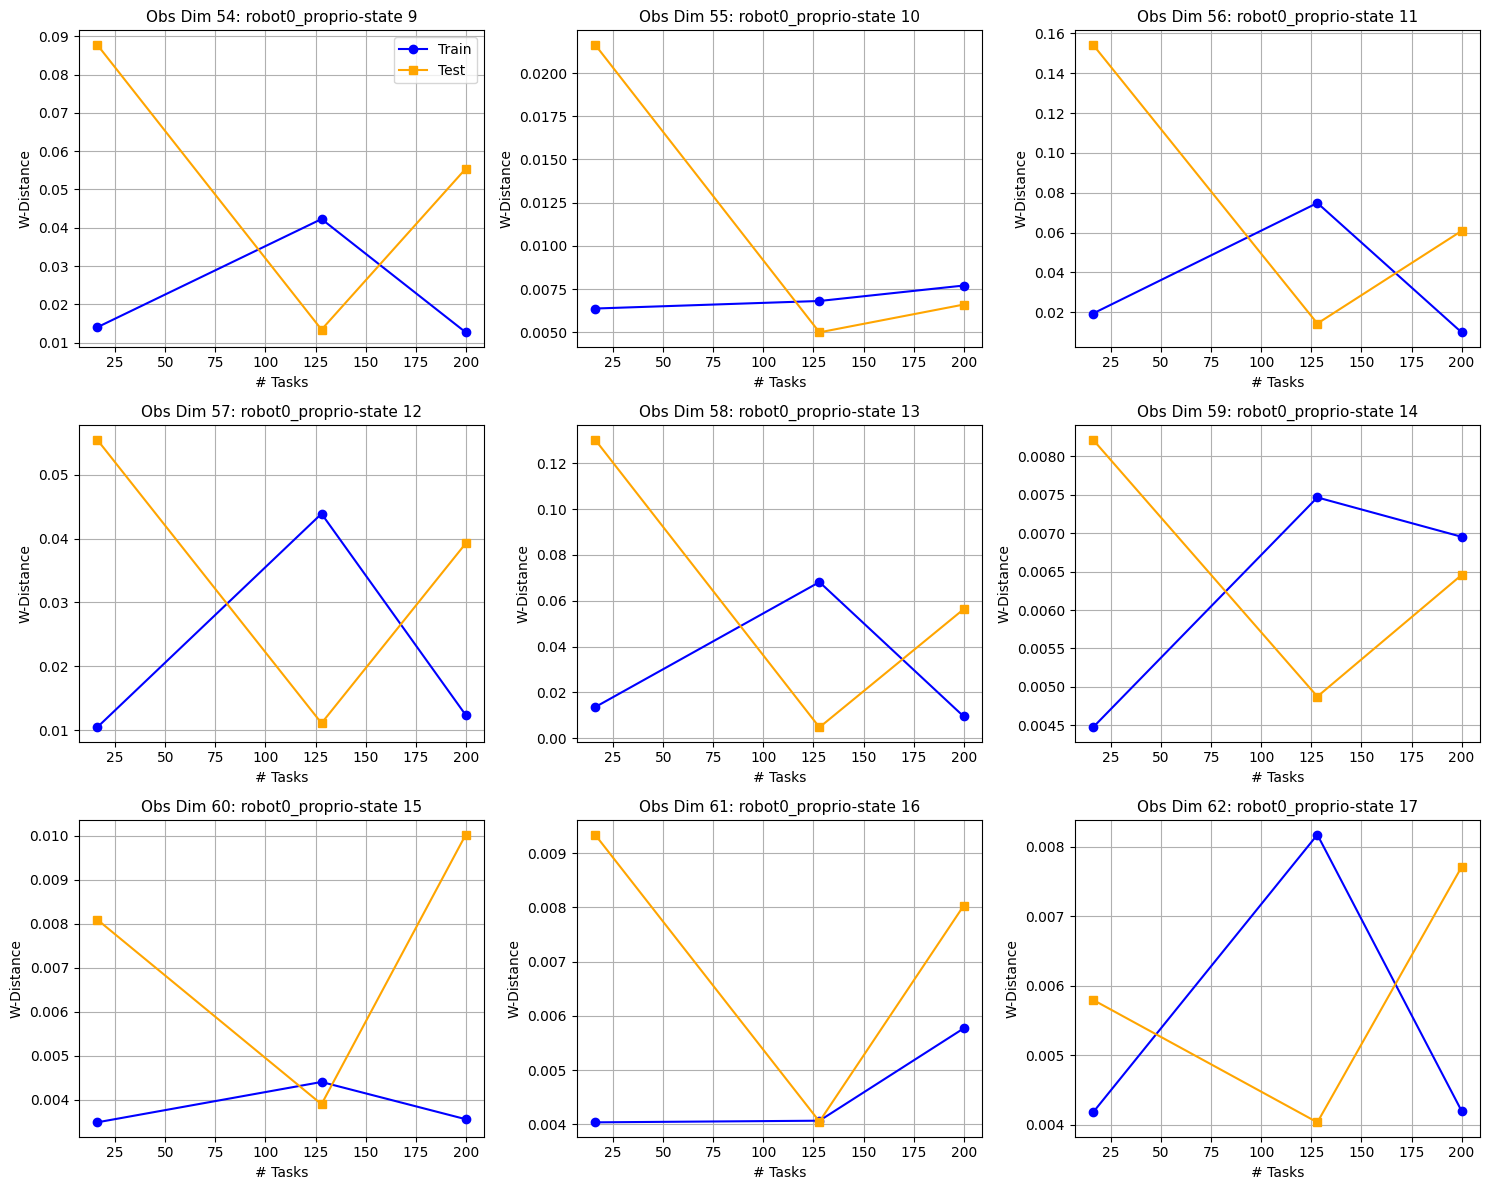

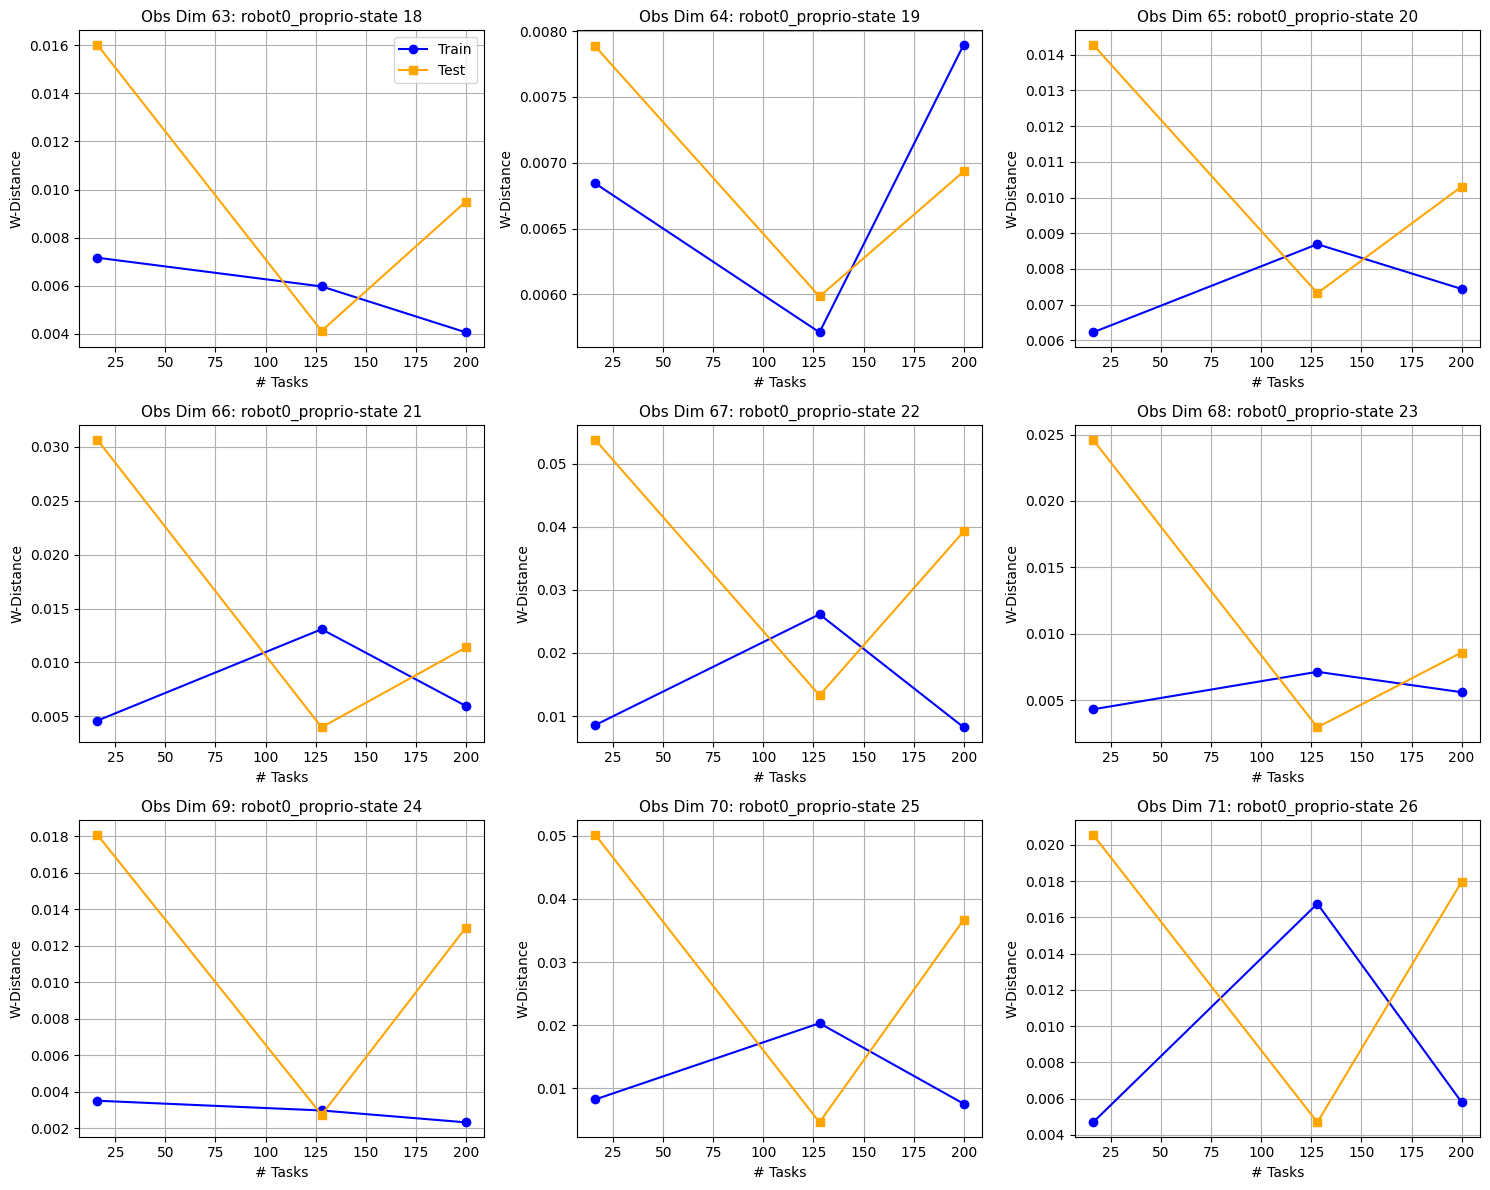

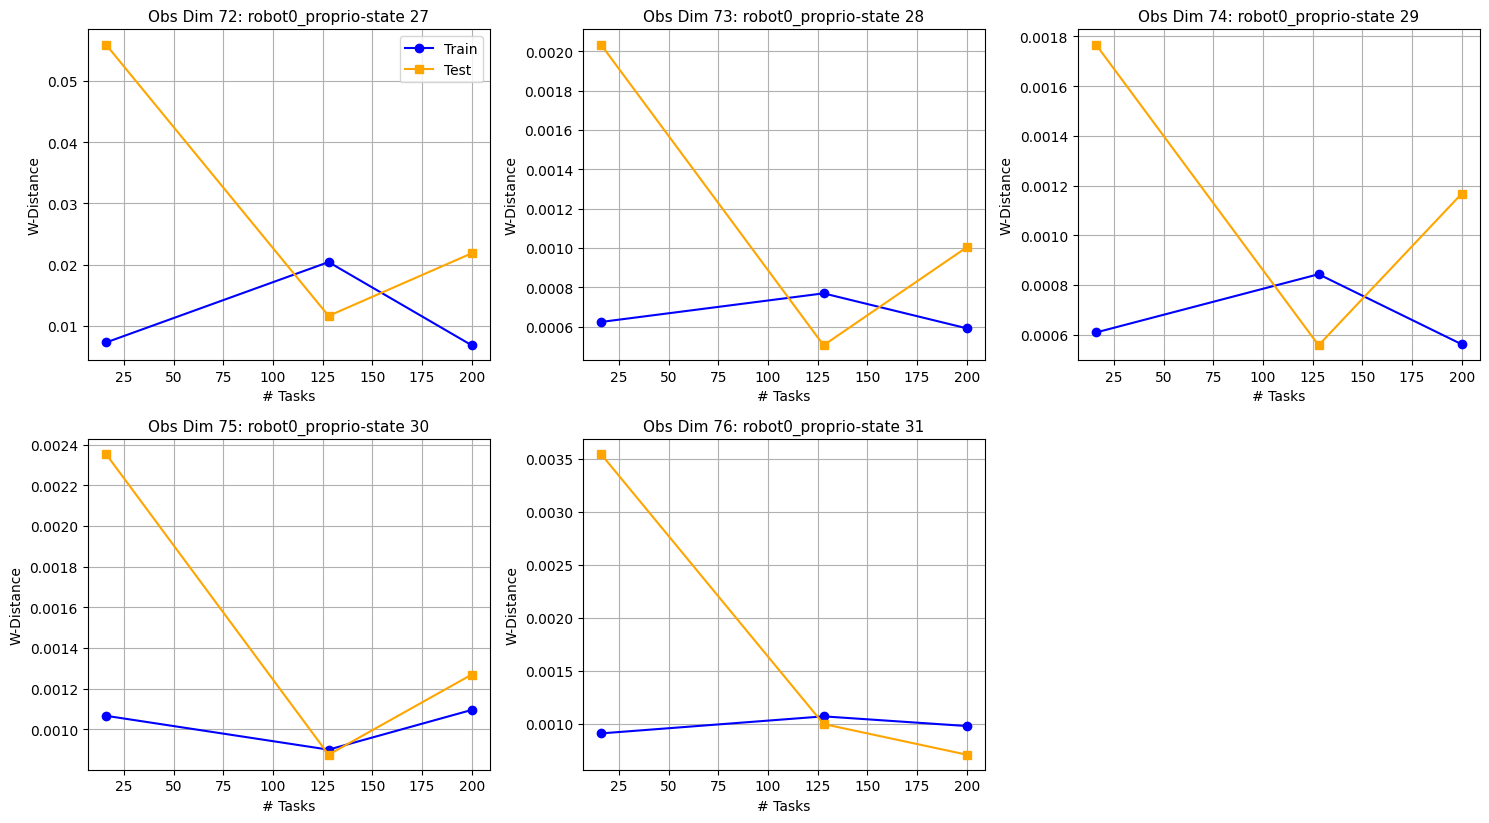

Plotting action dimensions...


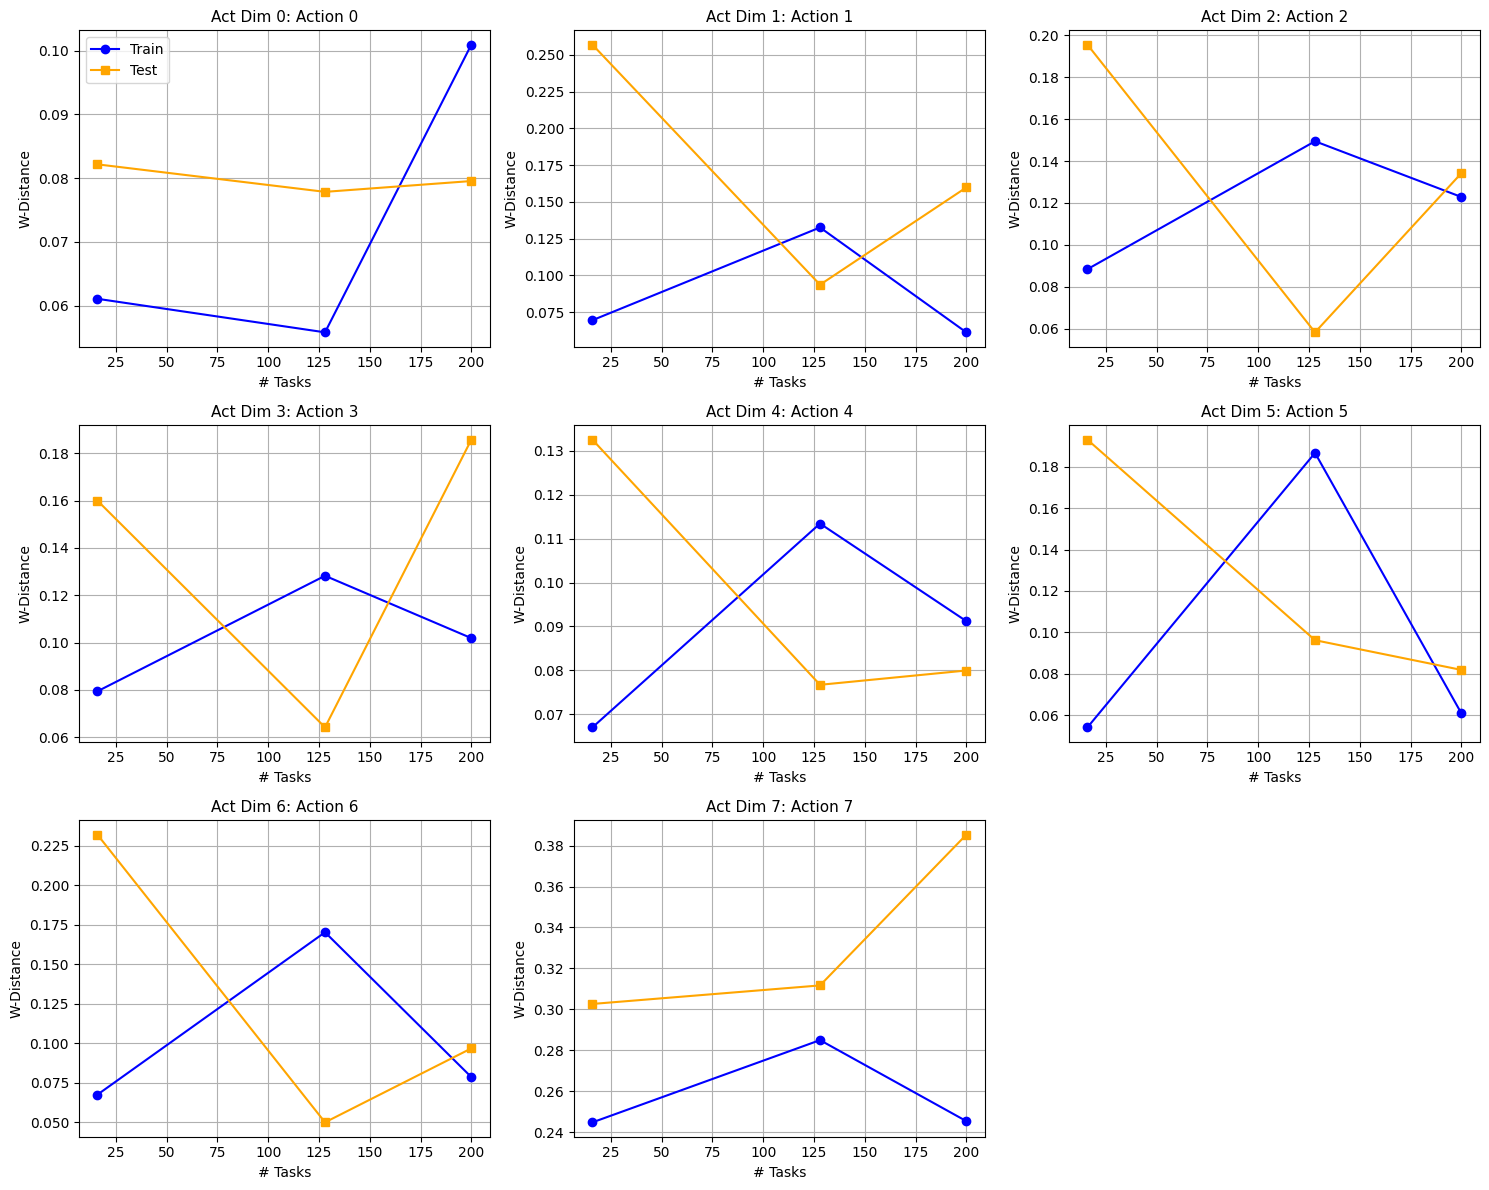

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [7]:
# For observations
modality_dims = representative_env.modality_dims

dim_names = []
start_idx = 0

for modality, (size,) in modality_dims.items():
    for i in range(size):
        dim_names.append(f"{modality} {i}")
    start_idx += size

# Convert to numpy arrays
train_obs_per_dim = np.array(all_train_obs_per_dim)
test_obs_per_dim = np.array(all_test_obs_per_dim)

n_dims = train_obs_per_dim.shape[1]  # Number of dimensions
n_cols = 3  # Number of columns in grid
n_rows = 3  # Number of rows per figure

dims_per_figure = n_cols * n_rows
total_figures = (n_dims + dims_per_figure - 1) // dims_per_figure

print("Plotting observation dimensions...")
for fig_idx in range(total_figures):
    plt.figure(figsize=(15, 12))
    
    start_dim = fig_idx * dims_per_figure
    end_dim = min(start_dim + dims_per_figure, n_dims)
    
    for i, dim_idx in enumerate(range(start_dim, end_dim)):
        plt.subplot(n_rows, n_cols, i + 1)
        
        train_dim_data = train_obs_per_dim[:, dim_idx]
        test_dim_data = test_obs_per_dim[:, dim_idx]
        
        # Get the dimension name
        dim_name = dim_names[dim_idx] if dim_idx < len(dim_names) else f"Unknown {dim_idx}"
        
        plt.plot(num_train_tasks, train_dim_data, label='Train', marker='o', linestyle='-', color='blue')
        plt.plot(num_train_tasks, test_dim_data, label='Test', marker='s', linestyle='-', color='orange')
        
        plt.xlabel('# Tasks', fontsize=10)
        plt.ylabel('W-Distance', fontsize=10)
        plt.title(f"Obs Dim {dim_idx}: {dim_name}", fontsize=11)
        plt.grid(True)
        
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()

# For actions
train_act_per_dim = np.array(all_train_act_per_dim)
test_act_per_dim = np.array(all_test_act_per_dim)

n_dims = train_act_per_dim.shape[1]  # Number of dimensions

print("Plotting action dimensions...")
for fig_idx in range(total_figures):
    plt.figure(figsize=(15, 12))
    
    start_dim = fig_idx * dims_per_figure
    end_dim = min(start_dim + dims_per_figure, n_dims)
    
    for i, dim_idx in enumerate(range(start_dim, end_dim)):
        plt.subplot(n_rows, n_cols, i + 1)
        
        train_dim_data = train_act_per_dim[:, dim_idx]
        test_dim_data = test_act_per_dim[:, dim_idx]
        
        # Get the dimension name for actions
        act_name = f"Action {dim_idx}"
        
        plt.plot(num_train_tasks, train_dim_data, label='Train', marker='o', linestyle='-', color='blue')
        plt.plot(num_train_tasks, test_dim_data, label='Test', marker='s', linestyle='-', color='orange')
        
        plt.xlabel('# Tasks', fontsize=10)
        plt.ylabel('W-Distance', fontsize=10)
        plt.title(f"Act Dim {dim_idx}: {act_name}", fontsize=11)
        plt.grid(True)
        
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [10]:
size

14

Plotting observations grouped by modality...


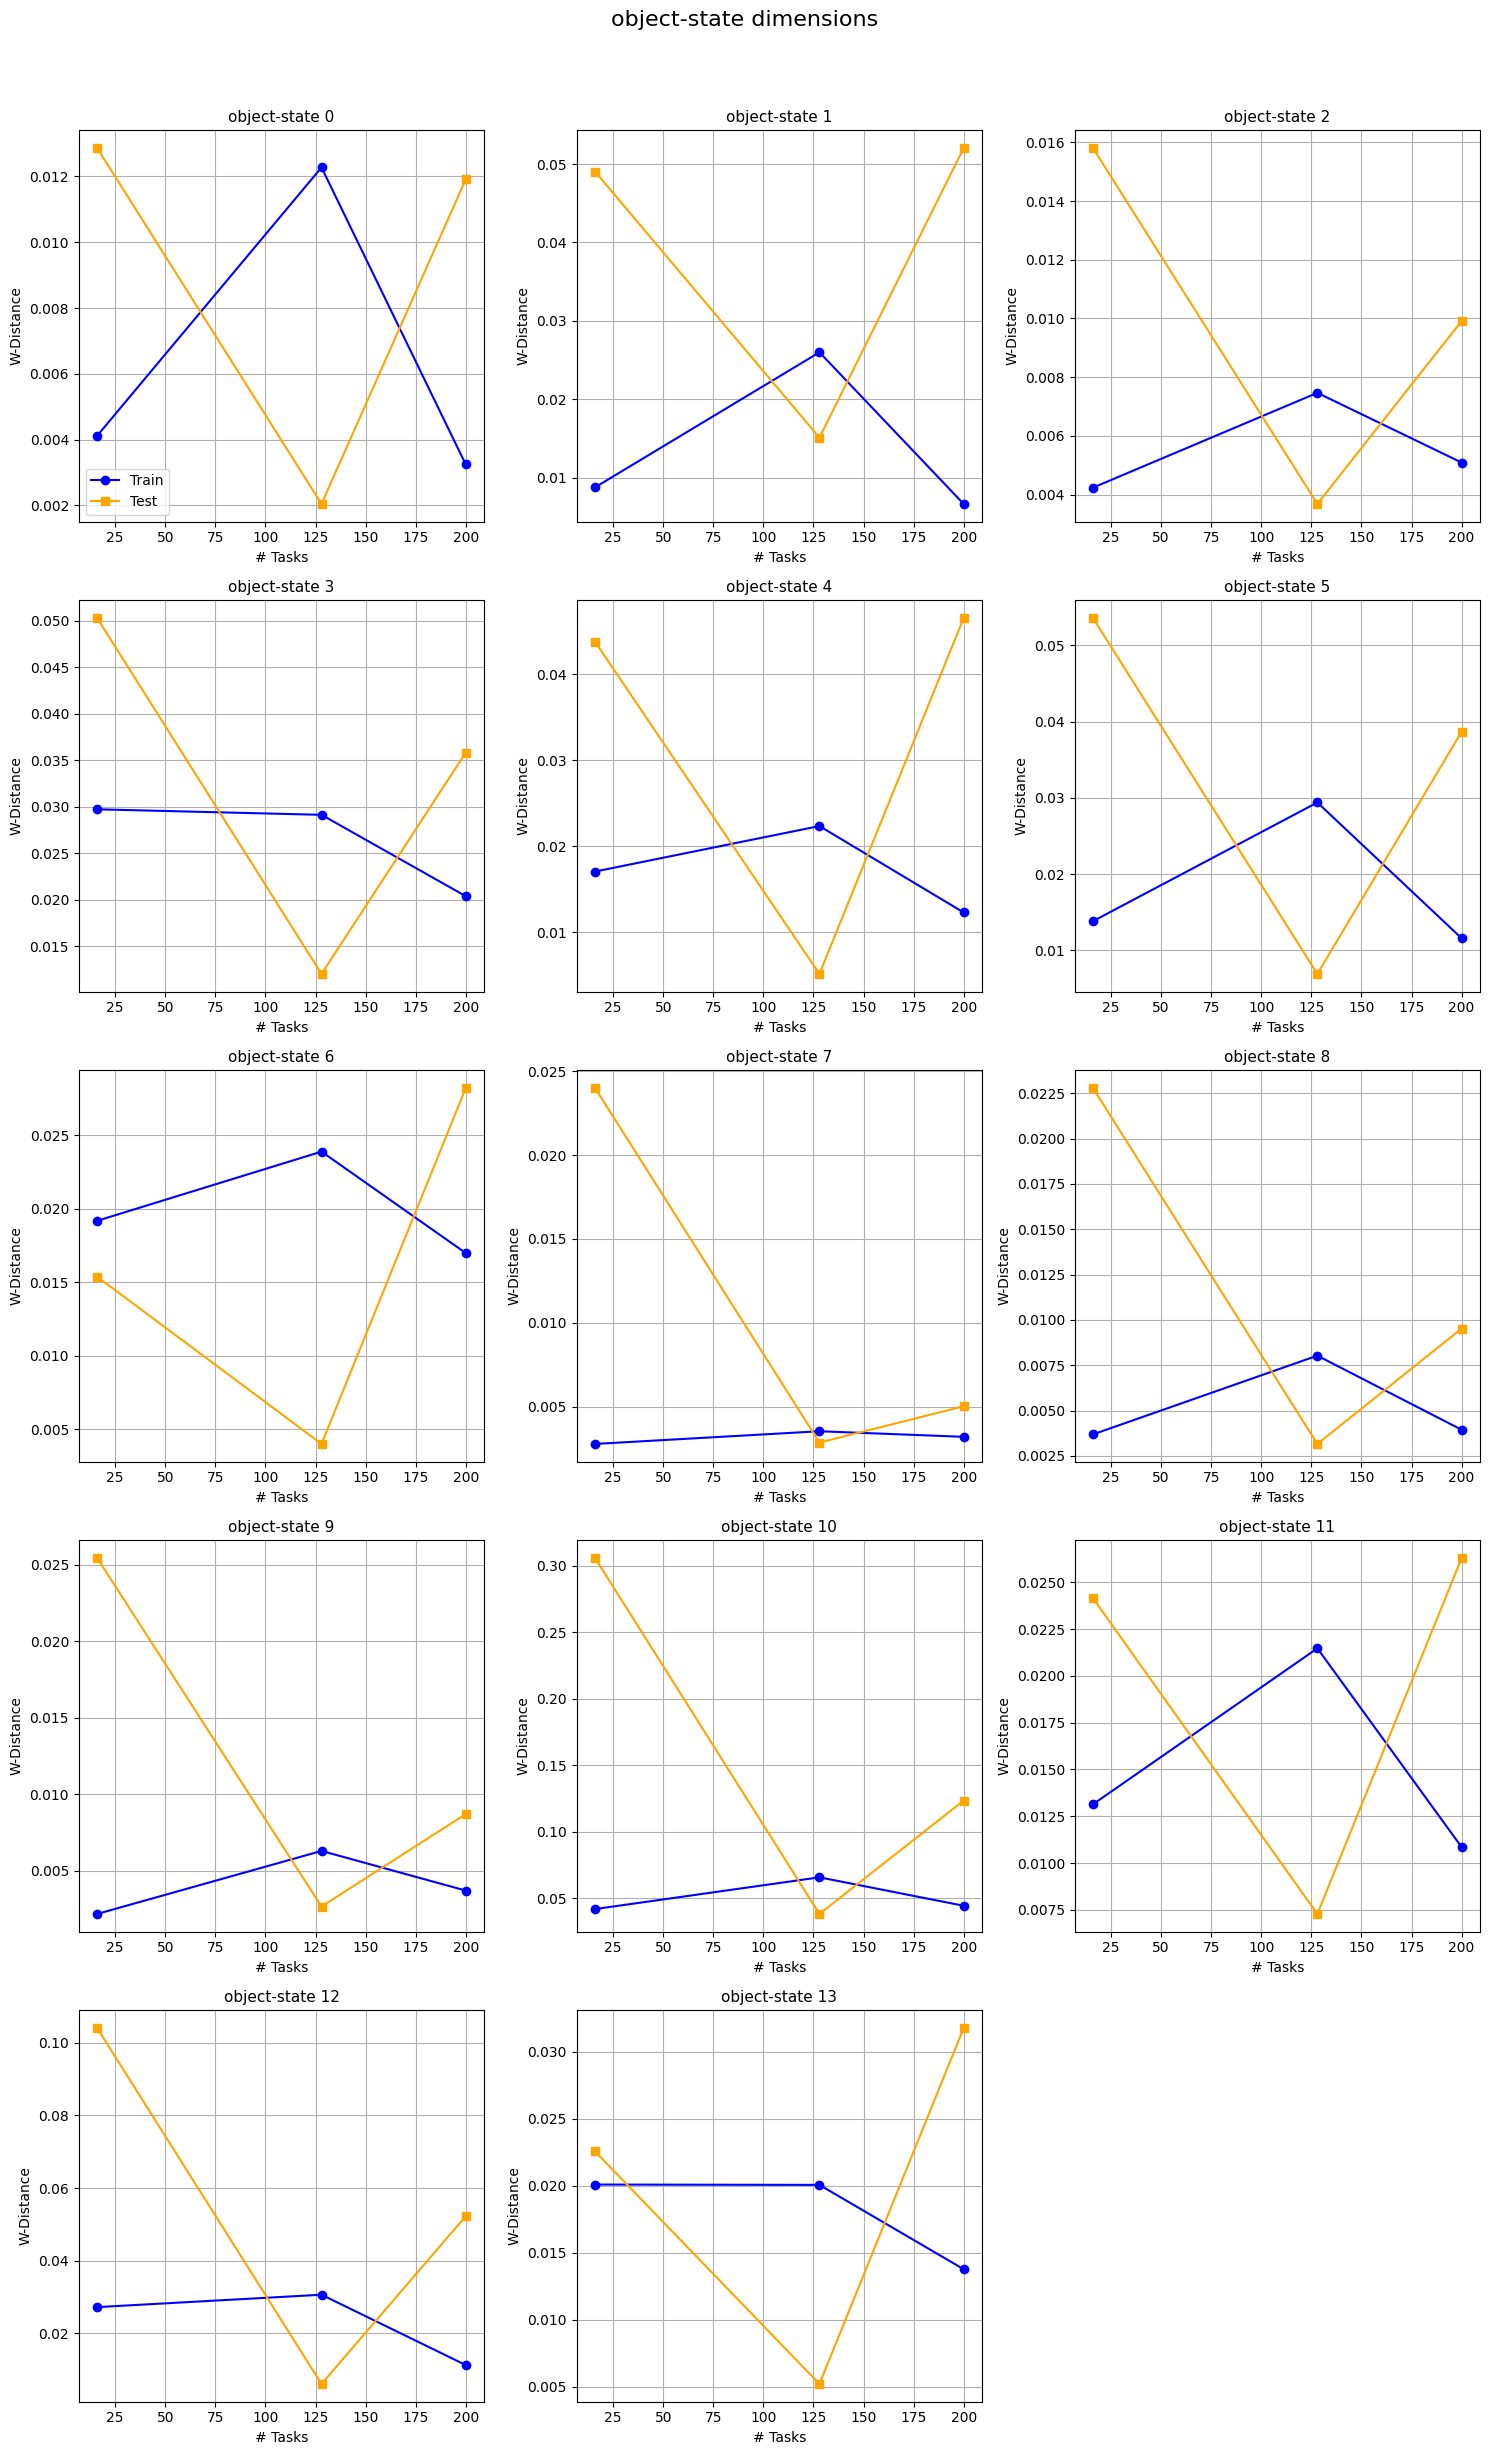

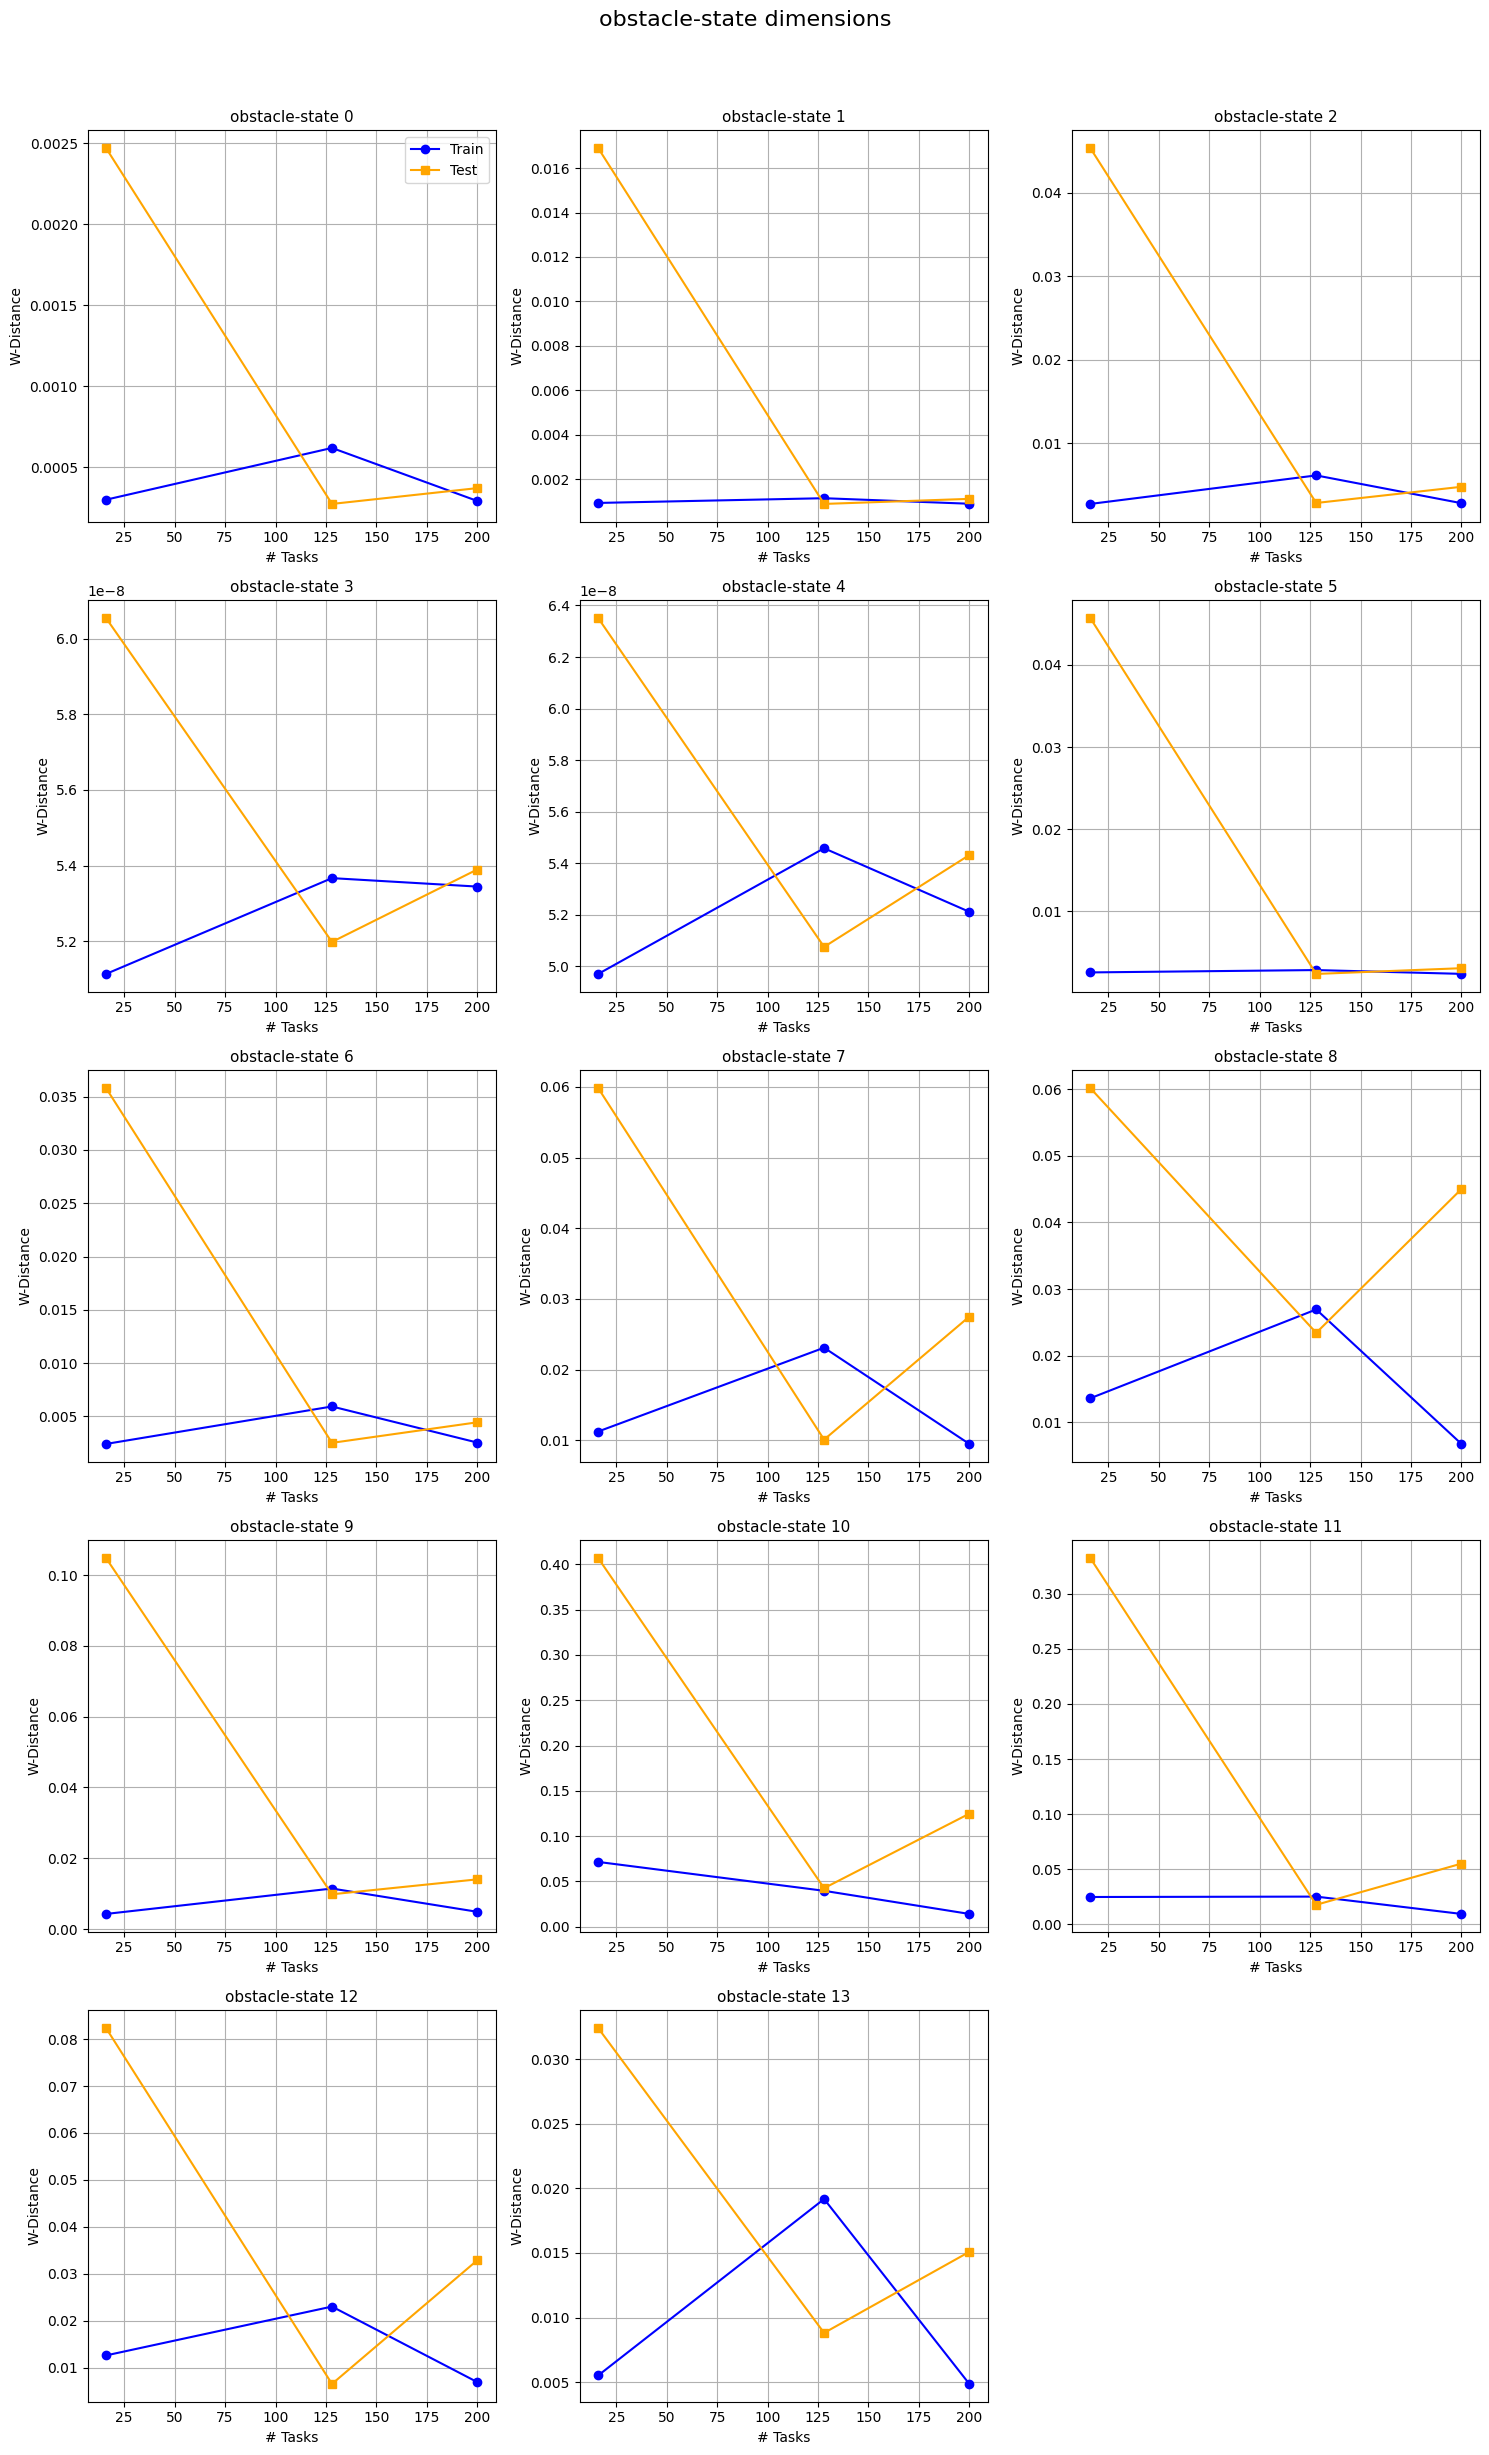

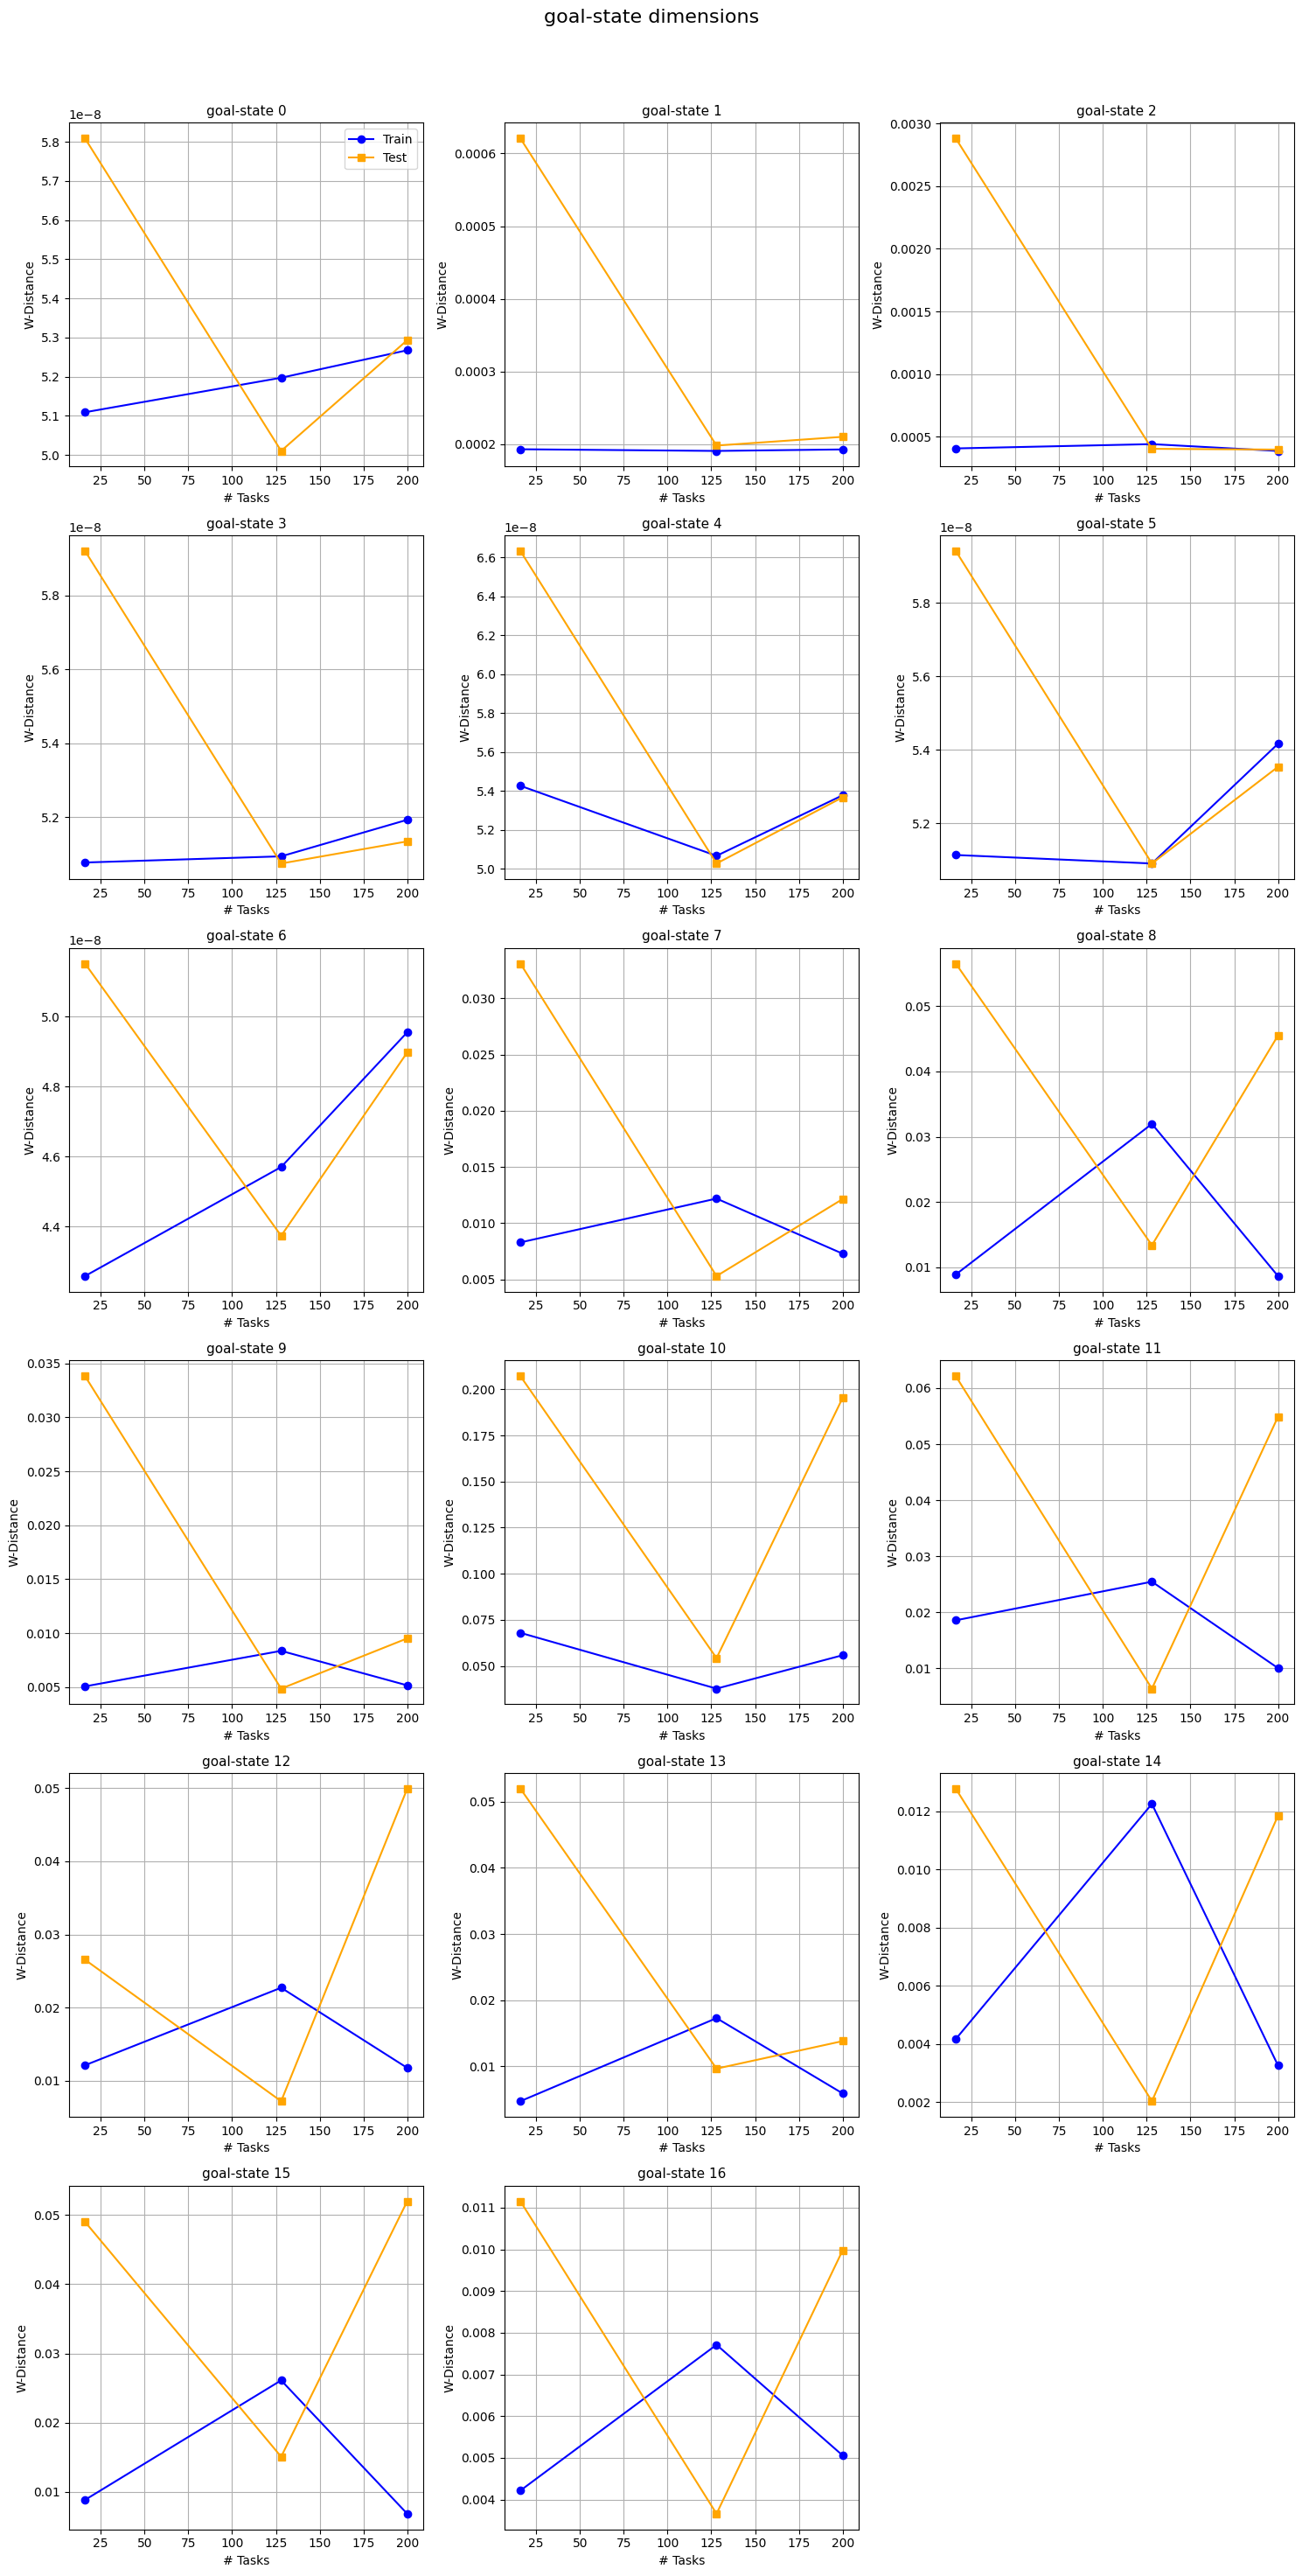

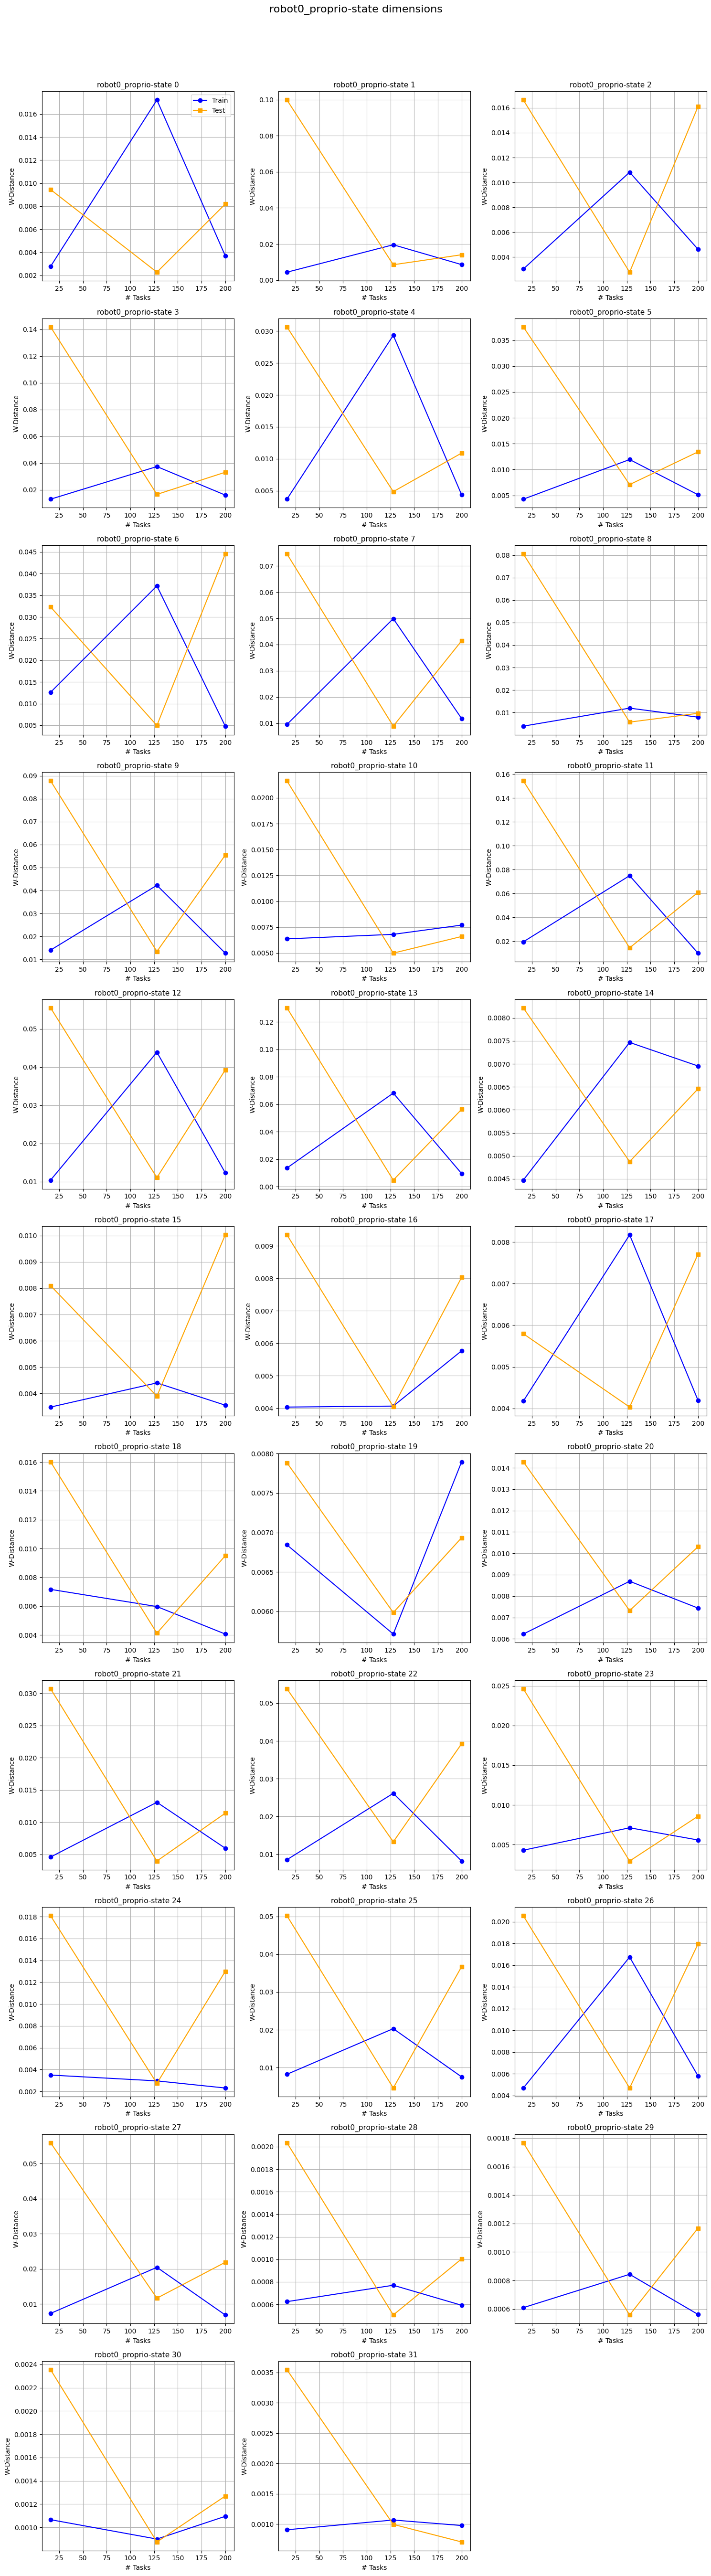

In [12]:
dim_to_modality = {}
start_idx = 0
for modality, (size,) in modality_dims.items():
    for i in range(size):
        dim_to_modality[start_idx + i] = modality
    start_idx += size

train_obs_per_dim = np.array(all_train_obs_per_dim)
test_obs_per_dim = np.array(all_test_obs_per_dim)

print("Plotting observations grouped by modality...")
for modality, (size,) in modality_dims.items():

    modality_indices = [i for i, mod in dim_to_modality.items() if mod == modality]
    n_dims = len(modality_indices)
    
    n_cols = 3
    n_rows = (n_dims + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(15, 5 * n_rows))
    
    for i, dim_idx in enumerate(modality_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        
        train_dim_data = train_obs_per_dim[:, dim_idx]
        test_dim_data = test_obs_per_dim[:, dim_idx]
        
        plt.plot(num_train_tasks, train_dim_data, label='Train', marker='o', linestyle='-', color='blue')
        plt.plot(num_train_tasks, test_dim_data, label='Test', marker='s', linestyle='-', color='orange')
        
        plt.xlabel('# Tasks', fontsize=10)
        plt.ylabel('W-Distance', fontsize=10)
        plt.title(f"{modality} {dim_idx - modality_indices[0]}", fontsize=11)
        plt.grid(True)
        
        if i == 0:
            plt.legend()
    
    plt.suptitle(f"{modality} dimensions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
